<a href="https://colab.research.google.com/github/sanketsans/Pix-2-Pix-GAN/blob/main/FridgeFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch.git

Cloning into 'pix2pix-pytorch'...
remote: Enumerating objects: 68, done.
remote: Total 68 (delta 0), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (68/68), done.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!cp '/content/gdrive/My Drive/11_4_converted/pix2pix-pytorch/networks.py' .

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np 
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from collections import deque
import random 
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle as pkl
from math import log10
from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = True if torch.cuda.is_available() else False

train_on_gpu

True

In [ ]:
del len

In [5]:
in_domain_imgs = '/content/gdrive/My Drive/in_domain/in_domain/'
synthetic_imgs = '/content/gdrive/My Drive/11_4_converted/11_4_converted/'
root_dir = '/content/gdrive/My Drive/'
os.chdir('/content/gdrive/My Drive/')

600 600 image_184.jpg


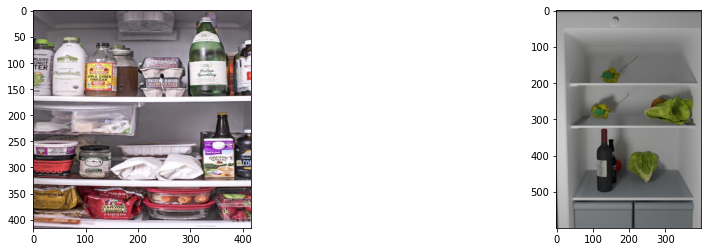

In [6]:
fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
N_in_domain_imgs = [name for name in os.listdir(in_domain_imgs)if '.jpg' in name]
N_synthetic_imgs = [name for name in os.listdir(synthetic_imgs) if '.jpg' in name]
N_in_domain_imgs = N_in_domain_imgs[0:600]

print(len(N_in_domain_imgs), len(N_synthetic_imgs), N_synthetic_imgs[5])
imgs = []
imgs.append(Image.open(in_domain_imgs + N_in_domain_imgs[45]))
imgs.append(Image.open(synthetic_imgs + N_synthetic_imgs[45]))
for ax, img in zip(axes.flatten(), imgs):
  i = ax.imshow(img)

plt.show()


In [7]:
class ImageDatasets(Dataset):
  def __init__(self, in_domain_imgs, synthetic_imgs, transform=None, device=None, indPath=None, synPath=None):
    self.indImgPath = indPath
    self.synImgPath = synPath
    self.transform = transform
    self.device = device 
    self.indImgs = in_domain_imgs
    self.synImgs = synthetic_imgs

  def __len__(self):
    if (len(self.indImgs) == len(self.synImgs)):
      return len(self.synImgs)

    else:
      return 0

  def __getitem__(self, index):

    targetImg = Image.open(self.indImgPath + self.indImgs[index])
    synImg = Image.open(self.synImgPath + self.synImgs[index])

    if self.transform:
      targetImg = self.transform(targetImg)
      synImg = self.transform(synImg)
    
    # feat_img = self.scale(feat_img)
    # target_img = self.scale(target_img)

    return targetImg.to(self.device), synImg.to(self.device)

  def scale(self, x, feature_range=(-1, 1)):
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()
                              ])

dataset = ImageDatasets(N_in_domain_imgs, N_synthetic_imgs, transform, device, in_domain_imgs, synthetic_imgs)
# Imgs_in_domain = datasets.ImageFolder(root_dir + 'in_domain/', transform=transform)
# Imgs_synthetic = datasets.ImageFolder(root_dir + '11_4_updated_images/', transform=transform)

dataset_size = len(dataset)
split = 0.9
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
# val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[int(dataset_size*split) :]

print(len(train_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


540 60


In [9]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=test_sampler)

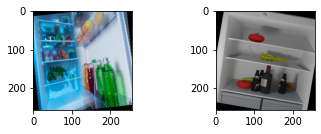

In [10]:
a = iter(trainLoader)
f, t = next(a)
feat = f[5].cpu()
tar = t[5].cpu()
i1 = torchvision.transforms.ToPILImage()(feat)
i2 = torchvision.transforms.ToPILImage()(tar)
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)
plt.show()

In [11]:
input_ch = 3
output_ch = 3
filter_first_layer = 64
net_g = define_G(input_ch, output_ch, filter_first_layer, norm='batch', use_dropout=False, init_type='normal',init_gain= 0.02, gpu_id=device)
net_d = define_D(input_ch + output_ch, filter_first_layer, 'basic', gpu_id=device)
net_g.load_state_dict(torch.load(synthetic_imgs + 'new_checkpoint_G.pth'))
net_d.load_state_dict(torch.load(synthetic_imgs + 'new_checkpoint_D.pth'))

initialize network with normal
initialize network with normal


<All keys matched successfully>

In [12]:
net_g

ResnetGenerator(
  (inc): Inconv(
    (inconv): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (down): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (resblocks): Sequential(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3)

In [13]:
net_d

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [20]:
criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

lr = 0.00025
beta1 = 0.5
lambdaL1 = 1.0
lossG, lossD = [], []
n_epochs = 30
samples = []
losses = []

optimizer_g = optim.Adam(net_g.parameters(), lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr, betas=(beta1, 0.999))

In [21]:
def scale(x, feature_range=(-1, 1)):
  # scale from 0-1 to feature_range
  min, max = feature_range
  x = x * (max - min) + min
  return x

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
      img = img.detach().cpu().numpy()
      img = np.transpose(img, (1, 2, 0))
      img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
      # print(min(img), max(img))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((256,256,3)))
    
    plt.show()

In [22]:
def trainingLoop(trainLoader, valLoader, n_epochs):
  min_loss = 10000.0

  iter_train_imgs = iter(trainLoader)
  iter_test_imgs = iter(testLoader)

  train_loss_deque = deque(maxlen=10)
  batch_per_epochs_train = len(trainLoader)
  batch_per_epoch_test = len(testLoader)

  for epoch in range(n_epochs):

    for iteration, batch in enumerate(trainLoader, 1):

      indImg, synImg = batch[0].to(device), batch[1].to(device)
      # if epoch % batch_per_epochs_train == 0:
      #   iter_train_imgs = iter(trainLoader)

      # indImg, synImg = next(iter_train_imgs)
      indImg = scale(indImg)
      synImg = scale(synImg)

      fake_indImg = net_g(synImg)

      ######################
      # (1) Update D network
      ######################

      optimizer_d.zero_grad()
      
      # train with fake
      fake_indsynImg = torch.cat((synImg, fake_indImg), 1)
      pred_fake = net_d.forward(fake_indsynImg.detach())
      loss_d_fake = criterionGAN(pred_fake, False)

      # train with real
      real_indsynImg = torch.cat((synImg, indImg), 1)
      pred_real = net_d.forward(real_indsynImg)
      loss_d_real = criterionGAN(pred_real, True)
      
      # Combined D loss
      loss_d = (loss_d_fake + loss_d_real) * 0.5

      loss_d.backward()
      
      optimizer_d.step()

      ######################
      # (2) Update G network
      ######################

      optimizer_g.zero_grad()

      # First, G(A) should fake the discriminator
      fake_indsynImg = torch.cat((synImg, fake_indImg), 1)
      pred_fake = net_d.forward(fake_indsynImg)
      loss_g_gan = criterionGAN(pred_fake, True)

      # Second, G(A) = B
      loss_g_l1 = criterionL1(fake_indImg, indImg) * lambdaL1
      
      loss_g = loss_g_gan + loss_g_l1
      
      loss_g.backward()

      optimizer_g.step()

      print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
          epoch, iteration, len(trainLoader), loss_d.item(), loss_g.item()))
      
      lossG.append(loss_g.item())
      lossD.append(loss_d.item())
    
    net_g.eval()
    with torch.no_grad():
      # test
      avg_psnr = 0
      for batch in testLoader:
          indImg, synImg = batch[0].to(device), batch[1].to(device)

          prediction = net_g(synImg)
          mse = criterionMSE(prediction, indImg)
          psnr = 10 * log10(1 / mse.item())
          avg_psnr += psnr
      print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testLoader)))

      if epoch % batch_per_epoch_test == 0:
        iter_test_imgs = iter(testLoader)
      indImg_test, synImg_test = next(iter_test_imgs)
      indImg_test = scale(indImg_test)
      synImg_test = scale(synImg_test)

      # if train_on_gpu:
      #   indImg_test = indImg_test.cuda()
      #   synImg_test = synImg_test.cuda()

      fakeImg = net_g(synImg_test)
      samples.append(fakeImg)
      _ = view_samples(-1, samples)

    net_g.train()

    if (epoch+1) % 5 == 0:
      print('saving data .. ')
      torch.save(net_g.state_dict(), synthetic_imgs + 'lowL1_new_checkpoint_G.pth')
      torch.save(net_d.state_dict(),  synthetic_imgs + 'lowL1_new_checkpoint_D.pth')

      # pkl_file = open(synthetic_imgs +  'Fride_train_samples_2.pkl', 'wb')
      # pkl.dump(samples, pkl_file)
      # pkl_file.close()



===> Epoch[0](1/54): Loss_D: 0.0118 Loss_G: 1.6011
===> Epoch[0](2/54): Loss_D: 0.2815 Loss_G: 1.2468
===> Epoch[0](3/54): Loss_D: 0.0284 Loss_G: 1.4677
===> Epoch[0](4/54): Loss_D: 0.0658 Loss_G: 1.4521
===> Epoch[0](5/54): Loss_D: 0.0502 Loss_G: 1.2634
===> Epoch[0](6/54): Loss_D: 0.0600 Loss_G: 1.3396
===> Epoch[0](7/54): Loss_D: 0.0642 Loss_G: 1.3984
===> Epoch[0](8/54): Loss_D: 0.1191 Loss_G: 1.5054
===> Epoch[0](9/54): Loss_D: 0.1696 Loss_G: 1.5019
===> Epoch[0](10/54): Loss_D: 0.2737 Loss_G: 1.3289
===> Epoch[0](11/54): Loss_D: 0.3334 Loss_G: 1.4751
===> Epoch[0](12/54): Loss_D: 0.3522 Loss_G: 1.3514
===> Epoch[0](13/54): Loss_D: 0.3894 Loss_G: 1.2014
===> Epoch[0](14/54): Loss_D: 0.4238 Loss_G: 1.4051
===> Epoch[0](15/54): Loss_D: 0.4924 Loss_G: 1.1296
===> Epoch[0](16/54): Loss_D: 0.3248 Loss_G: 1.3798
===> Epoch[0](17/54): Loss_D: 0.3110 Loss_G: 1.3452
===> Epoch[0](18/54): Loss_D: 0.3355 Loss_G: 1.2532
===> Epoch[0](19/54): Loss_D: 0.3480 Loss_G: 1.1850
===> Epoch[0](20/54):

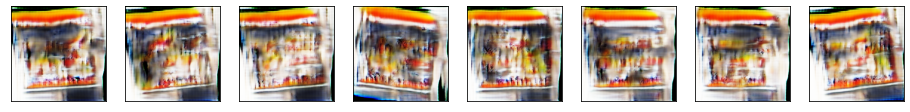

===> Epoch[1](1/54): Loss_D: 0.2855 Loss_G: 1.3251
===> Epoch[1](2/54): Loss_D: 0.2963 Loss_G: 1.0789
===> Epoch[1](3/54): Loss_D: 0.2504 Loss_G: 1.2681
===> Epoch[1](4/54): Loss_D: 0.2524 Loss_G: 1.1300
===> Epoch[1](5/54): Loss_D: 0.2441 Loss_G: 1.1252
===> Epoch[1](6/54): Loss_D: 0.2814 Loss_G: 1.0792
===> Epoch[1](7/54): Loss_D: 0.2233 Loss_G: 1.0863
===> Epoch[1](8/54): Loss_D: 0.1893 Loss_G: 1.1624
===> Epoch[1](9/54): Loss_D: 0.2045 Loss_G: 1.1453
===> Epoch[1](10/54): Loss_D: 0.2021 Loss_G: 1.1643
===> Epoch[1](11/54): Loss_D: 0.2254 Loss_G: 1.1308
===> Epoch[1](12/54): Loss_D: 0.2469 Loss_G: 1.2595
===> Epoch[1](13/54): Loss_D: 0.2532 Loss_G: 1.3648
===> Epoch[1](14/54): Loss_D: 0.2697 Loss_G: 1.0910
===> Epoch[1](15/54): Loss_D: 0.3011 Loss_G: 1.2390
===> Epoch[1](16/54): Loss_D: 0.3153 Loss_G: 1.1828
===> Epoch[1](17/54): Loss_D: 0.3086 Loss_G: 1.0379
===> Epoch[1](18/54): Loss_D: 0.2956 Loss_G: 1.1609
===> Epoch[1](19/54): Loss_D: 0.2779 Loss_G: 1.0031
===> Epoch[1](20/54):

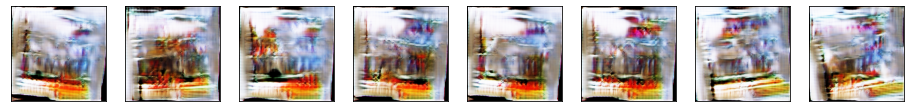

===> Epoch[2](1/54): Loss_D: 0.2213 Loss_G: 1.1143
===> Epoch[2](2/54): Loss_D: 0.2178 Loss_G: 1.0784
===> Epoch[2](3/54): Loss_D: 0.2494 Loss_G: 0.9852
===> Epoch[2](4/54): Loss_D: 0.2555 Loss_G: 1.0382
===> Epoch[2](5/54): Loss_D: 0.2591 Loss_G: 1.0346
===> Epoch[2](6/54): Loss_D: 0.2782 Loss_G: 0.9175
===> Epoch[2](7/54): Loss_D: 0.2399 Loss_G: 1.0727
===> Epoch[2](8/54): Loss_D: 0.2262 Loss_G: 1.0209
===> Epoch[2](9/54): Loss_D: 0.3073 Loss_G: 0.9570
===> Epoch[2](10/54): Loss_D: 0.2636 Loss_G: 0.9653
===> Epoch[2](11/54): Loss_D: 0.2612 Loss_G: 1.0491
===> Epoch[2](12/54): Loss_D: 0.2638 Loss_G: 1.0385
===> Epoch[2](13/54): Loss_D: 0.2509 Loss_G: 0.9670
===> Epoch[2](14/54): Loss_D: 0.2571 Loss_G: 0.9888
===> Epoch[2](15/54): Loss_D: 0.2299 Loss_G: 1.0287
===> Epoch[2](16/54): Loss_D: 0.2420 Loss_G: 0.9976
===> Epoch[2](17/54): Loss_D: 0.2290 Loss_G: 1.0569
===> Epoch[2](18/54): Loss_D: 0.2191 Loss_G: 1.0524
===> Epoch[2](19/54): Loss_D: 0.2141 Loss_G: 1.0430
===> Epoch[2](20/54):

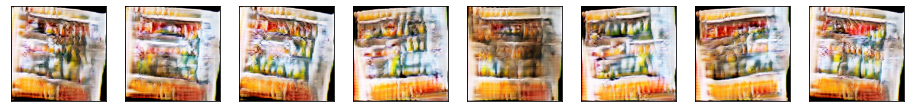

===> Epoch[3](1/54): Loss_D: 0.2479 Loss_G: 0.9647
===> Epoch[3](2/54): Loss_D: 0.2690 Loss_G: 0.9043
===> Epoch[3](3/54): Loss_D: 0.2391 Loss_G: 0.9683
===> Epoch[3](4/54): Loss_D: 0.2102 Loss_G: 1.1069
===> Epoch[3](5/54): Loss_D: 0.2099 Loss_G: 1.0542
===> Epoch[3](6/54): Loss_D: 0.2263 Loss_G: 1.0380
===> Epoch[3](7/54): Loss_D: 0.2546 Loss_G: 1.0627
===> Epoch[3](8/54): Loss_D: 0.2456 Loss_G: 1.0843
===> Epoch[3](9/54): Loss_D: 0.2001 Loss_G: 1.0805
===> Epoch[3](10/54): Loss_D: 0.2270 Loss_G: 1.0675
===> Epoch[3](11/54): Loss_D: 0.2176 Loss_G: 1.1037
===> Epoch[3](12/54): Loss_D: 0.1879 Loss_G: 1.1775
===> Epoch[3](13/54): Loss_D: 0.2218 Loss_G: 1.0229
===> Epoch[3](14/54): Loss_D: 0.2217 Loss_G: 1.4556
===> Epoch[3](15/54): Loss_D: 0.2665 Loss_G: 1.1052
===> Epoch[3](16/54): Loss_D: 0.2496 Loss_G: 1.1768
===> Epoch[3](17/54): Loss_D: 0.1957 Loss_G: 1.1144
===> Epoch[3](18/54): Loss_D: 0.2039 Loss_G: 1.0707
===> Epoch[3](19/54): Loss_D: 0.2347 Loss_G: 0.9837
===> Epoch[3](20/54):

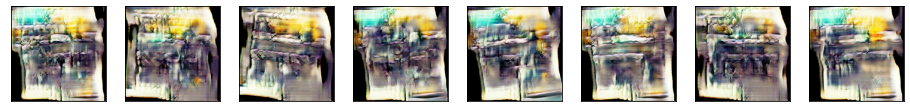

===> Epoch[4](1/54): Loss_D: 0.2513 Loss_G: 1.0505
===> Epoch[4](2/54): Loss_D: 0.2533 Loss_G: 1.0457
===> Epoch[4](3/54): Loss_D: 0.2731 Loss_G: 0.8784
===> Epoch[4](4/54): Loss_D: 0.2938 Loss_G: 1.1481
===> Epoch[4](5/54): Loss_D: 0.2576 Loss_G: 1.0780
===> Epoch[4](6/54): Loss_D: 0.2454 Loss_G: 1.0791
===> Epoch[4](7/54): Loss_D: 0.2171 Loss_G: 1.1772
===> Epoch[4](8/54): Loss_D: 0.2459 Loss_G: 1.1103
===> Epoch[4](9/54): Loss_D: 0.2077 Loss_G: 1.1706
===> Epoch[4](10/54): Loss_D: 0.2352 Loss_G: 1.1735
===> Epoch[4](11/54): Loss_D: 0.2172 Loss_G: 1.0963
===> Epoch[4](12/54): Loss_D: 0.2552 Loss_G: 1.1054
===> Epoch[4](13/54): Loss_D: 0.2634 Loss_G: 1.1207
===> Epoch[4](14/54): Loss_D: 0.2484 Loss_G: 1.0589
===> Epoch[4](15/54): Loss_D: 0.2686 Loss_G: 0.9903
===> Epoch[4](16/54): Loss_D: 0.2090 Loss_G: 1.0622
===> Epoch[4](17/54): Loss_D: 0.1943 Loss_G: 1.1555
===> Epoch[4](18/54): Loss_D: 0.2033 Loss_G: 1.0086
===> Epoch[4](19/54): Loss_D: 0.2077 Loss_G: 1.1500
===> Epoch[4](20/54):

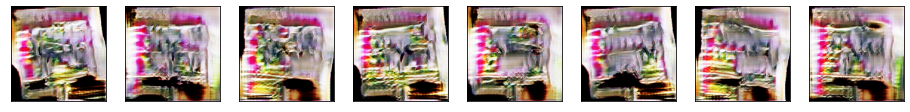

saving data .. 
===> Epoch[5](1/54): Loss_D: 0.2695 Loss_G: 0.9736
===> Epoch[5](2/54): Loss_D: 0.2048 Loss_G: 1.1532
===> Epoch[5](3/54): Loss_D: 0.2170 Loss_G: 1.1690
===> Epoch[5](4/54): Loss_D: 0.2142 Loss_G: 1.0703
===> Epoch[5](5/54): Loss_D: 0.2237 Loss_G: 1.2334
===> Epoch[5](6/54): Loss_D: 0.2364 Loss_G: 1.0387
===> Epoch[5](7/54): Loss_D: 0.2243 Loss_G: 1.0197
===> Epoch[5](8/54): Loss_D: 0.1886 Loss_G: 1.1345
===> Epoch[5](9/54): Loss_D: 0.2089 Loss_G: 0.9848
===> Epoch[5](10/54): Loss_D: 0.2145 Loss_G: 0.9579
===> Epoch[5](11/54): Loss_D: 0.2040 Loss_G: 1.1092
===> Epoch[5](12/54): Loss_D: 0.1943 Loss_G: 1.0809
===> Epoch[5](13/54): Loss_D: 0.1789 Loss_G: 1.0907
===> Epoch[5](14/54): Loss_D: 0.1728 Loss_G: 1.0935
===> Epoch[5](15/54): Loss_D: 0.2160 Loss_G: 0.9573
===> Epoch[5](16/54): Loss_D: 0.1932 Loss_G: 1.3366
===> Epoch[5](17/54): Loss_D: 0.2310 Loss_G: 1.1408
===> Epoch[5](18/54): Loss_D: 0.2274 Loss_G: 1.3410
===> Epoch[5](19/54): Loss_D: 0.2283 Loss_G: 1.1269
===> 

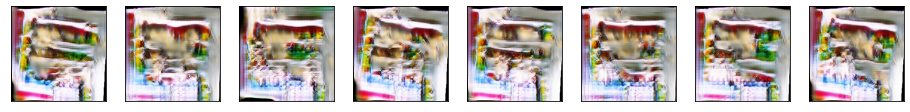

===> Epoch[6](1/54): Loss_D: 0.1794 Loss_G: 1.1701
===> Epoch[6](2/54): Loss_D: 0.1699 Loss_G: 1.2376
===> Epoch[6](3/54): Loss_D: 0.2076 Loss_G: 1.1395
===> Epoch[6](4/54): Loss_D: 0.2529 Loss_G: 1.3197
===> Epoch[6](5/54): Loss_D: 0.2565 Loss_G: 1.0074
===> Epoch[6](6/54): Loss_D: 0.2349 Loss_G: 0.9699
===> Epoch[6](7/54): Loss_D: 0.2518 Loss_G: 1.1889
===> Epoch[6](8/54): Loss_D: 0.2319 Loss_G: 1.0546
===> Epoch[6](9/54): Loss_D: 0.2768 Loss_G: 1.0406
===> Epoch[6](10/54): Loss_D: 0.2459 Loss_G: 1.1919
===> Epoch[6](11/54): Loss_D: 0.2355 Loss_G: 1.0656
===> Epoch[6](12/54): Loss_D: 0.2722 Loss_G: 1.1273
===> Epoch[6](13/54): Loss_D: 0.2598 Loss_G: 1.1750
===> Epoch[6](14/54): Loss_D: 0.2733 Loss_G: 1.1592
===> Epoch[6](15/54): Loss_D: 0.2526 Loss_G: 1.1817
===> Epoch[6](16/54): Loss_D: 0.1963 Loss_G: 1.0929
===> Epoch[6](17/54): Loss_D: 0.2011 Loss_G: 1.1204
===> Epoch[6](18/54): Loss_D: 0.2406 Loss_G: 1.0589
===> Epoch[6](19/54): Loss_D: 0.2606 Loss_G: 1.0214
===> Epoch[6](20/54):

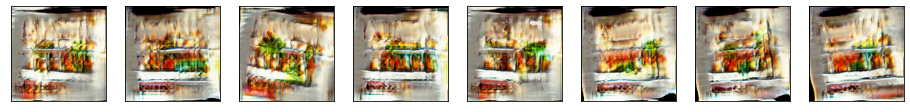

===> Epoch[7](1/54): Loss_D: 0.2108 Loss_G: 1.2193
===> Epoch[7](2/54): Loss_D: 0.2289 Loss_G: 1.1712
===> Epoch[7](3/54): Loss_D: 0.2730 Loss_G: 1.1554
===> Epoch[7](4/54): Loss_D: 0.2144 Loss_G: 1.1960
===> Epoch[7](5/54): Loss_D: 0.2192 Loss_G: 1.1414
===> Epoch[7](6/54): Loss_D: 0.2315 Loss_G: 1.1229
===> Epoch[7](7/54): Loss_D: 0.2230 Loss_G: 1.0296
===> Epoch[7](8/54): Loss_D: 0.2150 Loss_G: 1.0813
===> Epoch[7](9/54): Loss_D: 0.2074 Loss_G: 1.2895
===> Epoch[7](10/54): Loss_D: 0.2443 Loss_G: 0.9351
===> Epoch[7](11/54): Loss_D: 0.2321 Loss_G: 1.2107
===> Epoch[7](12/54): Loss_D: 0.2234 Loss_G: 1.0042
===> Epoch[7](13/54): Loss_D: 0.1728 Loss_G: 1.2391
===> Epoch[7](14/54): Loss_D: 0.1799 Loss_G: 1.0622
===> Epoch[7](15/54): Loss_D: 0.1940 Loss_G: 1.1652
===> Epoch[7](16/54): Loss_D: 0.1754 Loss_G: 1.1895
===> Epoch[7](17/54): Loss_D: 0.2065 Loss_G: 1.0818
===> Epoch[7](18/54): Loss_D: 0.2117 Loss_G: 1.1899
===> Epoch[7](19/54): Loss_D: 0.2136 Loss_G: 1.0109
===> Epoch[7](20/54):

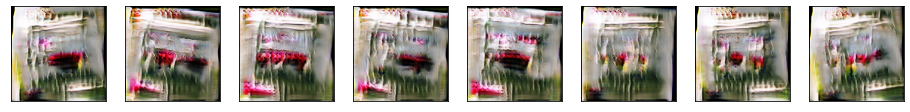

===> Epoch[8](1/54): Loss_D: 0.2167 Loss_G: 1.3024
===> Epoch[8](2/54): Loss_D: 0.2011 Loss_G: 1.1085
===> Epoch[8](3/54): Loss_D: 0.2171 Loss_G: 1.1720
===> Epoch[8](4/54): Loss_D: 0.2321 Loss_G: 1.1459
===> Epoch[8](5/54): Loss_D: 0.2807 Loss_G: 1.0393
===> Epoch[8](6/54): Loss_D: 0.2579 Loss_G: 1.1285
===> Epoch[8](7/54): Loss_D: 0.2813 Loss_G: 1.2896
===> Epoch[8](8/54): Loss_D: 0.3393 Loss_G: 1.0072
===> Epoch[8](9/54): Loss_D: 0.2838 Loss_G: 1.1768
===> Epoch[8](10/54): Loss_D: 0.2630 Loss_G: 1.0645
===> Epoch[8](11/54): Loss_D: 0.2262 Loss_G: 1.0211
===> Epoch[8](12/54): Loss_D: 0.2142 Loss_G: 1.0668
===> Epoch[8](13/54): Loss_D: 0.2154 Loss_G: 0.9895
===> Epoch[8](14/54): Loss_D: 0.2165 Loss_G: 1.0316
===> Epoch[8](15/54): Loss_D: 0.2208 Loss_G: 0.9767
===> Epoch[8](16/54): Loss_D: 0.2079 Loss_G: 1.0926
===> Epoch[8](17/54): Loss_D: 0.2109 Loss_G: 1.0660
===> Epoch[8](18/54): Loss_D: 0.2313 Loss_G: 0.9331
===> Epoch[8](19/54): Loss_D: 0.2181 Loss_G: 0.9645
===> Epoch[8](20/54):

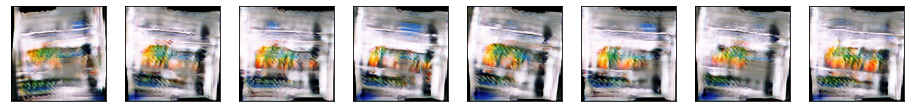

===> Epoch[9](1/54): Loss_D: 0.2189 Loss_G: 1.2131
===> Epoch[9](2/54): Loss_D: 0.2347 Loss_G: 1.0149
===> Epoch[9](3/54): Loss_D: 0.2271 Loss_G: 1.0435
===> Epoch[9](4/54): Loss_D: 0.2144 Loss_G: 1.1628
===> Epoch[9](5/54): Loss_D: 0.2127 Loss_G: 1.0965
===> Epoch[9](6/54): Loss_D: 0.2324 Loss_G: 1.1561
===> Epoch[9](7/54): Loss_D: 0.2528 Loss_G: 1.1371
===> Epoch[9](8/54): Loss_D: 0.2259 Loss_G: 1.1033
===> Epoch[9](9/54): Loss_D: 0.2426 Loss_G: 1.0462
===> Epoch[9](10/54): Loss_D: 0.2340 Loss_G: 0.9934
===> Epoch[9](11/54): Loss_D: 0.2382 Loss_G: 1.0619
===> Epoch[9](12/54): Loss_D: 0.2117 Loss_G: 1.0349
===> Epoch[9](13/54): Loss_D: 0.2114 Loss_G: 1.0109
===> Epoch[9](14/54): Loss_D: 0.1824 Loss_G: 1.0586
===> Epoch[9](15/54): Loss_D: 0.2046 Loss_G: 1.0762
===> Epoch[9](16/54): Loss_D: 0.1758 Loss_G: 1.1001
===> Epoch[9](17/54): Loss_D: 0.2067 Loss_G: 1.0546
===> Epoch[9](18/54): Loss_D: 0.2286 Loss_G: 1.0232
===> Epoch[9](19/54): Loss_D: 0.2032 Loss_G: 1.2047
===> Epoch[9](20/54):

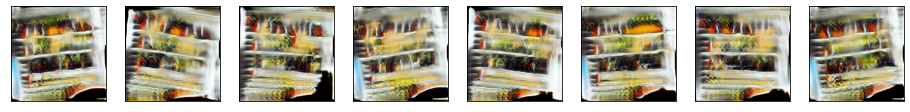

saving data .. 
===> Epoch[10](1/54): Loss_D: 0.2266 Loss_G: 1.4635
===> Epoch[10](2/54): Loss_D: 0.2677 Loss_G: 1.0055
===> Epoch[10](3/54): Loss_D: 0.2258 Loss_G: 1.1509
===> Epoch[10](4/54): Loss_D: 0.1949 Loss_G: 1.1266
===> Epoch[10](5/54): Loss_D: 0.2154 Loss_G: 1.1804
===> Epoch[10](6/54): Loss_D: 0.1762 Loss_G: 1.2173
===> Epoch[10](7/54): Loss_D: 0.1809 Loss_G: 1.2325
===> Epoch[10](8/54): Loss_D: 0.1711 Loss_G: 1.4056
===> Epoch[10](9/54): Loss_D: 0.2282 Loss_G: 1.0289
===> Epoch[10](10/54): Loss_D: 0.2328 Loss_G: 1.3566
===> Epoch[10](11/54): Loss_D: 0.2632 Loss_G: 1.1939
===> Epoch[10](12/54): Loss_D: 0.2824 Loss_G: 1.1689
===> Epoch[10](13/54): Loss_D: 0.2618 Loss_G: 1.0340
===> Epoch[10](14/54): Loss_D: 0.2315 Loss_G: 1.2655
===> Epoch[10](15/54): Loss_D: 0.2651 Loss_G: 0.9734
===> Epoch[10](16/54): Loss_D: 0.2468 Loss_G: 1.1102
===> Epoch[10](17/54): Loss_D: 0.2253 Loss_G: 1.0978
===> Epoch[10](18/54): Loss_D: 0.1748 Loss_G: 1.0659
===> Epoch[10](19/54): Loss_D: 0.1963 L

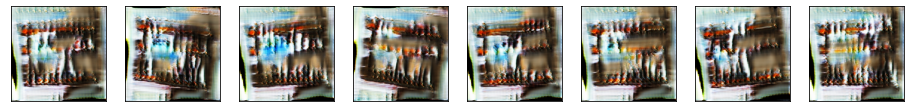

===> Epoch[11](1/54): Loss_D: 0.2690 Loss_G: 1.2618
===> Epoch[11](2/54): Loss_D: 0.2564 Loss_G: 1.3487
===> Epoch[11](3/54): Loss_D: 0.1985 Loss_G: 1.1885
===> Epoch[11](4/54): Loss_D: 0.1750 Loss_G: 1.3203
===> Epoch[11](5/54): Loss_D: 0.1789 Loss_G: 1.2272
===> Epoch[11](6/54): Loss_D: 0.2197 Loss_G: 1.0287
===> Epoch[11](7/54): Loss_D: 0.1957 Loss_G: 1.4081
===> Epoch[11](8/54): Loss_D: 0.2010 Loss_G: 1.1707
===> Epoch[11](9/54): Loss_D: 0.1938 Loss_G: 1.4493
===> Epoch[11](10/54): Loss_D: 0.1542 Loss_G: 1.3891
===> Epoch[11](11/54): Loss_D: 0.1801 Loss_G: 1.2992
===> Epoch[11](12/54): Loss_D: 0.2264 Loss_G: 1.0782
===> Epoch[11](13/54): Loss_D: 0.2357 Loss_G: 1.1393
===> Epoch[11](14/54): Loss_D: 0.2029 Loss_G: 1.1040
===> Epoch[11](15/54): Loss_D: 0.2096 Loss_G: 1.1427
===> Epoch[11](16/54): Loss_D: 0.1901 Loss_G: 1.0937
===> Epoch[11](17/54): Loss_D: 0.2639 Loss_G: 0.9674
===> Epoch[11](18/54): Loss_D: 0.2203 Loss_G: 1.4828
===> Epoch[11](19/54): Loss_D: 0.2073 Loss_G: 0.9488
==

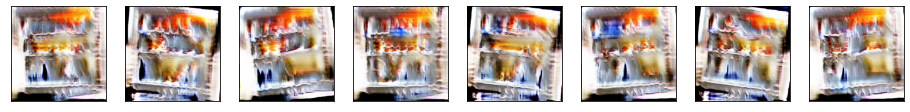

===> Epoch[12](1/54): Loss_D: 0.2509 Loss_G: 0.9464
===> Epoch[12](2/54): Loss_D: 0.2637 Loss_G: 1.2348
===> Epoch[12](3/54): Loss_D: 0.2444 Loss_G: 1.3339
===> Epoch[12](4/54): Loss_D: 0.2782 Loss_G: 1.2135
===> Epoch[12](5/54): Loss_D: 0.2922 Loss_G: 1.3333
===> Epoch[12](6/54): Loss_D: 0.2821 Loss_G: 1.2724
===> Epoch[12](7/54): Loss_D: 0.3204 Loss_G: 1.5609
===> Epoch[12](8/54): Loss_D: 0.2836 Loss_G: 0.9667
===> Epoch[12](9/54): Loss_D: 0.2618 Loss_G: 1.1975
===> Epoch[12](10/54): Loss_D: 0.1916 Loss_G: 1.1076
===> Epoch[12](11/54): Loss_D: 0.1809 Loss_G: 1.1033
===> Epoch[12](12/54): Loss_D: 0.1883 Loss_G: 1.0980
===> Epoch[12](13/54): Loss_D: 0.1940 Loss_G: 1.0852
===> Epoch[12](14/54): Loss_D: 0.1902 Loss_G: 1.2316
===> Epoch[12](15/54): Loss_D: 0.2294 Loss_G: 0.9788
===> Epoch[12](16/54): Loss_D: 0.2226 Loss_G: 1.5932
===> Epoch[12](17/54): Loss_D: 0.2455 Loss_G: 1.0306
===> Epoch[12](18/54): Loss_D: 0.1737 Loss_G: 1.1626
===> Epoch[12](19/54): Loss_D: 0.1923 Loss_G: 1.2573
==

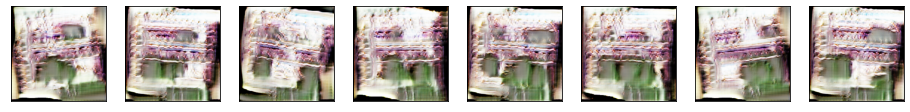

===> Epoch[13](1/54): Loss_D: 0.2411 Loss_G: 0.8434
===> Epoch[13](2/54): Loss_D: 0.2798 Loss_G: 1.5552
===> Epoch[13](3/54): Loss_D: 0.2368 Loss_G: 1.1254
===> Epoch[13](4/54): Loss_D: 0.2151 Loss_G: 1.0230
===> Epoch[13](5/54): Loss_D: 0.2321 Loss_G: 1.0453
===> Epoch[13](6/54): Loss_D: 0.1962 Loss_G: 1.2432
===> Epoch[13](7/54): Loss_D: 0.1933 Loss_G: 1.0667
===> Epoch[13](8/54): Loss_D: 0.1844 Loss_G: 1.1404
===> Epoch[13](9/54): Loss_D: 0.1518 Loss_G: 1.1966
===> Epoch[13](10/54): Loss_D: 0.1785 Loss_G: 0.9965
===> Epoch[13](11/54): Loss_D: 0.2205 Loss_G: 1.0342
===> Epoch[13](12/54): Loss_D: 0.1441 Loss_G: 1.5612
===> Epoch[13](13/54): Loss_D: 0.2915 Loss_G: 0.8343
===> Epoch[13](14/54): Loss_D: 0.2563 Loss_G: 1.3287
===> Epoch[13](15/54): Loss_D: 0.2293 Loss_G: 1.0684
===> Epoch[13](16/54): Loss_D: 0.2258 Loss_G: 0.9870
===> Epoch[13](17/54): Loss_D: 0.2131 Loss_G: 1.1730
===> Epoch[13](18/54): Loss_D: 0.2299 Loss_G: 1.0126
===> Epoch[13](19/54): Loss_D: 0.1703 Loss_G: 1.2790
==

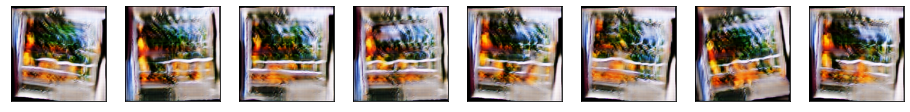

===> Epoch[14](1/54): Loss_D: 0.2351 Loss_G: 1.5128
===> Epoch[14](2/54): Loss_D: 0.2649 Loss_G: 1.0452
===> Epoch[14](3/54): Loss_D: 0.2231 Loss_G: 1.5187
===> Epoch[14](4/54): Loss_D: 0.2921 Loss_G: 1.1577
===> Epoch[14](5/54): Loss_D: 0.2666 Loss_G: 1.2159
===> Epoch[14](6/54): Loss_D: 0.2243 Loss_G: 1.2085
===> Epoch[14](7/54): Loss_D: 0.1857 Loss_G: 1.1492
===> Epoch[14](8/54): Loss_D: 0.2192 Loss_G: 1.0947
===> Epoch[14](9/54): Loss_D: 0.1925 Loss_G: 1.1435
===> Epoch[14](10/54): Loss_D: 0.1789 Loss_G: 1.0356
===> Epoch[14](11/54): Loss_D: 0.2218 Loss_G: 1.0718
===> Epoch[14](12/54): Loss_D: 0.1703 Loss_G: 1.1431
===> Epoch[14](13/54): Loss_D: 0.2175 Loss_G: 1.0066
===> Epoch[14](14/54): Loss_D: 0.1858 Loss_G: 1.0744
===> Epoch[14](15/54): Loss_D: 0.1846 Loss_G: 1.1896
===> Epoch[14](16/54): Loss_D: 0.2104 Loss_G: 1.0111
===> Epoch[14](17/54): Loss_D: 0.1842 Loss_G: 1.3280
===> Epoch[14](18/54): Loss_D: 0.2294 Loss_G: 0.8769
===> Epoch[14](19/54): Loss_D: 0.2368 Loss_G: 1.2840
==

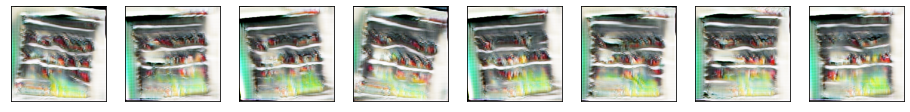

saving data .. 
===> Epoch[15](1/54): Loss_D: 0.1692 Loss_G: 1.3455
===> Epoch[15](2/54): Loss_D: 0.1673 Loss_G: 1.3454
===> Epoch[15](3/54): Loss_D: 0.1661 Loss_G: 1.5303
===> Epoch[15](4/54): Loss_D: 0.2089 Loss_G: 1.2660
===> Epoch[15](5/54): Loss_D: 0.2673 Loss_G: 1.6821
===> Epoch[15](6/54): Loss_D: 0.3601 Loss_G: 1.8300
===> Epoch[15](7/54): Loss_D: 0.4115 Loss_G: 1.1790
===> Epoch[15](8/54): Loss_D: 0.4314 Loss_G: 2.0946
===> Epoch[15](9/54): Loss_D: 0.4081 Loss_G: 1.0048
===> Epoch[15](10/54): Loss_D: 0.2625 Loss_G: 1.0587
===> Epoch[15](11/54): Loss_D: 0.2874 Loss_G: 1.2563
===> Epoch[15](12/54): Loss_D: 0.2111 Loss_G: 1.1650
===> Epoch[15](13/54): Loss_D: 0.1706 Loss_G: 1.1296
===> Epoch[15](14/54): Loss_D: 0.1733 Loss_G: 1.1659
===> Epoch[15](15/54): Loss_D: 0.1769 Loss_G: 1.1648
===> Epoch[15](16/54): Loss_D: 0.1851 Loss_G: 1.1840
===> Epoch[15](17/54): Loss_D: 0.2089 Loss_G: 1.0703
===> Epoch[15](18/54): Loss_D: 0.1825 Loss_G: 1.1972
===> Epoch[15](19/54): Loss_D: 0.2362 L

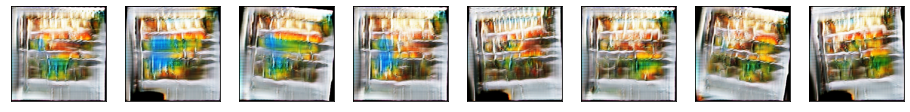

===> Epoch[16](1/54): Loss_D: 0.1902 Loss_G: 1.1560
===> Epoch[16](2/54): Loss_D: 0.1793 Loss_G: 1.1469
===> Epoch[16](3/54): Loss_D: 0.1828 Loss_G: 1.2502
===> Epoch[16](4/54): Loss_D: 0.1767 Loss_G: 1.1755
===> Epoch[16](5/54): Loss_D: 0.1738 Loss_G: 1.1502
===> Epoch[16](6/54): Loss_D: 0.1447 Loss_G: 1.2314
===> Epoch[16](7/54): Loss_D: 0.1446 Loss_G: 1.3121
===> Epoch[16](8/54): Loss_D: 0.2199 Loss_G: 1.1363
===> Epoch[16](9/54): Loss_D: 0.1959 Loss_G: 1.4067
===> Epoch[16](10/54): Loss_D: 0.2536 Loss_G: 1.1364
===> Epoch[16](11/54): Loss_D: 0.2349 Loss_G: 1.4225
===> Epoch[16](12/54): Loss_D: 0.2109 Loss_G: 1.3423
===> Epoch[16](13/54): Loss_D: 0.1989 Loss_G: 1.1806
===> Epoch[16](14/54): Loss_D: 0.2192 Loss_G: 1.0863
===> Epoch[16](15/54): Loss_D: 0.2182 Loss_G: 1.3277
===> Epoch[16](16/54): Loss_D: 0.1994 Loss_G: 1.1069
===> Epoch[16](17/54): Loss_D: 0.2000 Loss_G: 1.1292
===> Epoch[16](18/54): Loss_D: 0.1957 Loss_G: 1.2916
===> Epoch[16](19/54): Loss_D: 0.2192 Loss_G: 1.1855
==

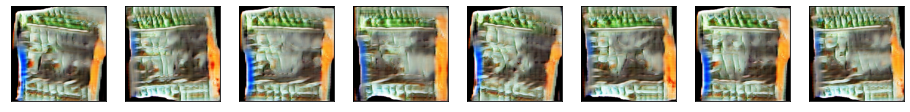

===> Epoch[17](1/54): Loss_D: 0.1621 Loss_G: 1.1131
===> Epoch[17](2/54): Loss_D: 0.1807 Loss_G: 1.2167
===> Epoch[17](3/54): Loss_D: 0.1525 Loss_G: 1.3269
===> Epoch[17](4/54): Loss_D: 0.1790 Loss_G: 1.1060
===> Epoch[17](5/54): Loss_D: 0.1722 Loss_G: 1.4583
===> Epoch[17](6/54): Loss_D: 0.1737 Loss_G: 1.0944
===> Epoch[17](7/54): Loss_D: 0.1787 Loss_G: 1.4278
===> Epoch[17](8/54): Loss_D: 0.2054 Loss_G: 1.7161
===> Epoch[17](9/54): Loss_D: 0.2217 Loss_G: 1.0972
===> Epoch[17](10/54): Loss_D: 0.2187 Loss_G: 1.4190
===> Epoch[17](11/54): Loss_D: 0.1996 Loss_G: 1.4397
===> Epoch[17](12/54): Loss_D: 0.1791 Loss_G: 1.1990
===> Epoch[17](13/54): Loss_D: 0.1779 Loss_G: 1.4838
===> Epoch[17](14/54): Loss_D: 0.1862 Loss_G: 1.3039
===> Epoch[17](15/54): Loss_D: 0.1669 Loss_G: 1.4102
===> Epoch[17](16/54): Loss_D: 0.2017 Loss_G: 1.3214
===> Epoch[17](17/54): Loss_D: 0.1896 Loss_G: 1.2564
===> Epoch[17](18/54): Loss_D: 0.1777 Loss_G: 1.3336
===> Epoch[17](19/54): Loss_D: 0.2107 Loss_G: 1.6503
==

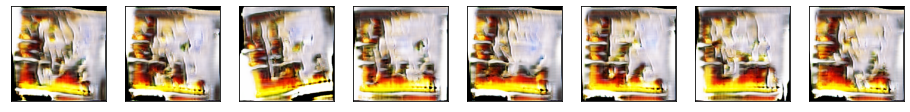

===> Epoch[18](1/54): Loss_D: 0.1998 Loss_G: 1.3740
===> Epoch[18](2/54): Loss_D: 0.2147 Loss_G: 1.0943
===> Epoch[18](3/54): Loss_D: 0.2070 Loss_G: 1.1013
===> Epoch[18](4/54): Loss_D: 0.1678 Loss_G: 1.2581
===> Epoch[18](5/54): Loss_D: 0.1648 Loss_G: 1.1075
===> Epoch[18](6/54): Loss_D: 0.1613 Loss_G: 1.2362
===> Epoch[18](7/54): Loss_D: 0.1953 Loss_G: 1.1313
===> Epoch[18](8/54): Loss_D: 0.1801 Loss_G: 1.1560
===> Epoch[18](9/54): Loss_D: 0.1760 Loss_G: 1.2300
===> Epoch[18](10/54): Loss_D: 0.1766 Loss_G: 1.1826
===> Epoch[18](11/54): Loss_D: 0.1386 Loss_G: 1.3887
===> Epoch[18](12/54): Loss_D: 0.1562 Loss_G: 1.0798
===> Epoch[18](13/54): Loss_D: 0.1957 Loss_G: 1.0868
===> Epoch[18](14/54): Loss_D: 0.1741 Loss_G: 1.2057
===> Epoch[18](15/54): Loss_D: 0.1489 Loss_G: 1.3542
===> Epoch[18](16/54): Loss_D: 0.1842 Loss_G: 1.1198
===> Epoch[18](17/54): Loss_D: 0.2038 Loss_G: 1.2011
===> Epoch[18](18/54): Loss_D: 0.1925 Loss_G: 1.2090
===> Epoch[18](19/54): Loss_D: 0.2329 Loss_G: 1.0287
==

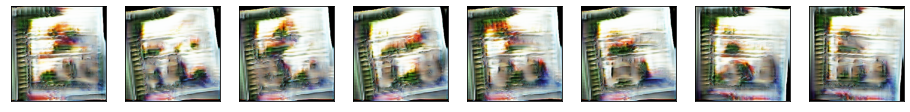

===> Epoch[19](1/54): Loss_D: 0.1847 Loss_G: 1.1680
===> Epoch[19](2/54): Loss_D: 0.2245 Loss_G: 1.0661
===> Epoch[19](3/54): Loss_D: 0.1607 Loss_G: 1.3649
===> Epoch[19](4/54): Loss_D: 0.1689 Loss_G: 1.2243
===> Epoch[19](5/54): Loss_D: 0.1793 Loss_G: 1.2178
===> Epoch[19](6/54): Loss_D: 0.1636 Loss_G: 1.3771
===> Epoch[19](7/54): Loss_D: 0.1301 Loss_G: 1.3800
===> Epoch[19](8/54): Loss_D: 0.1689 Loss_G: 1.3535
===> Epoch[19](9/54): Loss_D: 0.1711 Loss_G: 1.0459
===> Epoch[19](10/54): Loss_D: 0.1745 Loss_G: 1.3482
===> Epoch[19](11/54): Loss_D: 0.1473 Loss_G: 1.3135
===> Epoch[19](12/54): Loss_D: 0.1643 Loss_G: 1.0519
===> Epoch[19](13/54): Loss_D: 0.1626 Loss_G: 1.2719
===> Epoch[19](14/54): Loss_D: 0.1303 Loss_G: 1.2845
===> Epoch[19](15/54): Loss_D: 0.1470 Loss_G: 1.2708
===> Epoch[19](16/54): Loss_D: 0.1724 Loss_G: 1.5698
===> Epoch[19](17/54): Loss_D: 0.1921 Loss_G: 0.9826
===> Epoch[19](18/54): Loss_D: 0.2091 Loss_G: 1.5689
===> Epoch[19](19/54): Loss_D: 0.1948 Loss_G: 1.3676
==

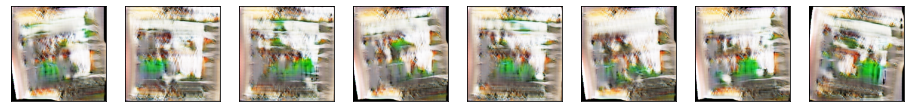

saving data .. 
===> Epoch[20](1/54): Loss_D: 0.1304 Loss_G: 1.1528
===> Epoch[20](2/54): Loss_D: 0.1240 Loss_G: 1.1110
===> Epoch[20](3/54): Loss_D: 0.2254 Loss_G: 1.3743
===> Epoch[20](4/54): Loss_D: 0.2242 Loss_G: 1.1272
===> Epoch[20](5/54): Loss_D: 0.1846 Loss_G: 1.2410
===> Epoch[20](6/54): Loss_D: 0.1866 Loss_G: 1.2792
===> Epoch[20](7/54): Loss_D: 0.1928 Loss_G: 1.1549
===> Epoch[20](8/54): Loss_D: 0.2479 Loss_G: 1.7590
===> Epoch[20](9/54): Loss_D: 0.2548 Loss_G: 1.1939
===> Epoch[20](10/54): Loss_D: 0.2751 Loss_G: 1.4100
===> Epoch[20](11/54): Loss_D: 0.1835 Loss_G: 1.4140
===> Epoch[20](12/54): Loss_D: 0.2162 Loss_G: 1.1414
===> Epoch[20](13/54): Loss_D: 0.1875 Loss_G: 1.4309
===> Epoch[20](14/54): Loss_D: 0.2116 Loss_G: 1.1156
===> Epoch[20](15/54): Loss_D: 0.1239 Loss_G: 1.1889
===> Epoch[20](16/54): Loss_D: 0.1459 Loss_G: 1.6549
===> Epoch[20](17/54): Loss_D: 0.1437 Loss_G: 1.3639
===> Epoch[20](18/54): Loss_D: 0.1828 Loss_G: 1.2588
===> Epoch[20](19/54): Loss_D: 0.1660 L

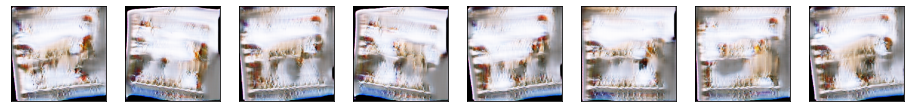

===> Epoch[21](1/54): Loss_D: 0.1518 Loss_G: 1.3405
===> Epoch[21](2/54): Loss_D: 0.1950 Loss_G: 1.0472
===> Epoch[21](3/54): Loss_D: 0.1700 Loss_G: 1.1874
===> Epoch[21](4/54): Loss_D: 0.1499 Loss_G: 1.2848
===> Epoch[21](5/54): Loss_D: 0.1656 Loss_G: 1.1337
===> Epoch[21](6/54): Loss_D: 0.1601 Loss_G: 1.1399
===> Epoch[21](7/54): Loss_D: 0.1770 Loss_G: 1.3155
===> Epoch[21](8/54): Loss_D: 0.1610 Loss_G: 1.1260
===> Epoch[21](9/54): Loss_D: 0.1579 Loss_G: 1.0838
===> Epoch[21](10/54): Loss_D: 0.1453 Loss_G: 1.3783
===> Epoch[21](11/54): Loss_D: 0.1762 Loss_G: 1.1170
===> Epoch[21](12/54): Loss_D: 0.1343 Loss_G: 1.5354
===> Epoch[21](13/54): Loss_D: 0.2168 Loss_G: 1.0113
===> Epoch[21](14/54): Loss_D: 0.2161 Loss_G: 1.3197
===> Epoch[21](15/54): Loss_D: 0.2134 Loss_G: 1.1593
===> Epoch[21](16/54): Loss_D: 0.1912 Loss_G: 0.9683
===> Epoch[21](17/54): Loss_D: 0.1884 Loss_G: 1.3145
===> Epoch[21](18/54): Loss_D: 0.1542 Loss_G: 1.2355
===> Epoch[21](19/54): Loss_D: 0.1983 Loss_G: 0.9309
==

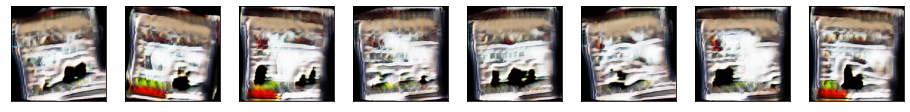

===> Epoch[22](1/54): Loss_D: 0.2140 Loss_G: 1.3619
===> Epoch[22](2/54): Loss_D: 0.1754 Loss_G: 1.5920
===> Epoch[22](3/54): Loss_D: 0.1787 Loss_G: 1.4569
===> Epoch[22](4/54): Loss_D: 0.1992 Loss_G: 1.9705
===> Epoch[22](5/54): Loss_D: 0.2082 Loss_G: 1.1520
===> Epoch[22](6/54): Loss_D: 0.2634 Loss_G: 1.5254
===> Epoch[22](7/54): Loss_D: 0.2644 Loss_G: 1.3047
===> Epoch[22](8/54): Loss_D: 0.2174 Loss_G: 1.1684
===> Epoch[22](9/54): Loss_D: 0.1988 Loss_G: 1.4277
===> Epoch[22](10/54): Loss_D: 0.1486 Loss_G: 1.2049
===> Epoch[22](11/54): Loss_D: 0.1877 Loss_G: 1.2175
===> Epoch[22](12/54): Loss_D: 0.1487 Loss_G: 1.3382
===> Epoch[22](13/54): Loss_D: 0.1397 Loss_G: 1.1925
===> Epoch[22](14/54): Loss_D: 0.1754 Loss_G: 1.1072
===> Epoch[22](15/54): Loss_D: 0.2248 Loss_G: 1.5025
===> Epoch[22](16/54): Loss_D: 0.1923 Loss_G: 1.2527
===> Epoch[22](17/54): Loss_D: 0.2361 Loss_G: 1.0995
===> Epoch[22](18/54): Loss_D: 0.2200 Loss_G: 1.8839
===> Epoch[22](19/54): Loss_D: 0.2777 Loss_G: 1.0153
==

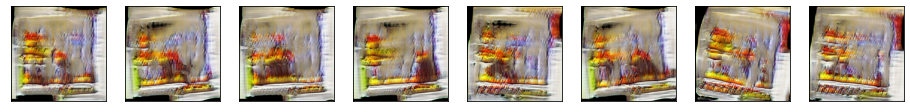

===> Epoch[23](1/54): Loss_D: 0.2140 Loss_G: 1.0192
===> Epoch[23](2/54): Loss_D: 0.1790 Loss_G: 1.1508
===> Epoch[23](3/54): Loss_D: 0.1594 Loss_G: 1.3055
===> Epoch[23](4/54): Loss_D: 0.1775 Loss_G: 1.1420
===> Epoch[23](5/54): Loss_D: 0.2041 Loss_G: 1.9441
===> Epoch[23](6/54): Loss_D: 0.3729 Loss_G: 1.3400
===> Epoch[23](7/54): Loss_D: 0.3698 Loss_G: 1.4492
===> Epoch[23](8/54): Loss_D: 0.2887 Loss_G: 1.4003
===> Epoch[23](9/54): Loss_D: 0.2878 Loss_G: 0.9668
===> Epoch[23](10/54): Loss_D: 0.2042 Loss_G: 1.1207
===> Epoch[23](11/54): Loss_D: 0.2138 Loss_G: 1.0865
===> Epoch[23](12/54): Loss_D: 0.1962 Loss_G: 1.0597
===> Epoch[23](13/54): Loss_D: 0.1762 Loss_G: 1.1910
===> Epoch[23](14/54): Loss_D: 0.1442 Loss_G: 1.2409
===> Epoch[23](15/54): Loss_D: 0.1712 Loss_G: 1.1159
===> Epoch[23](16/54): Loss_D: 0.2188 Loss_G: 1.1361
===> Epoch[23](17/54): Loss_D: 0.1906 Loss_G: 1.2440
===> Epoch[23](18/54): Loss_D: 0.2153 Loss_G: 0.9485
===> Epoch[23](19/54): Loss_D: 0.2458 Loss_G: 1.1086
==

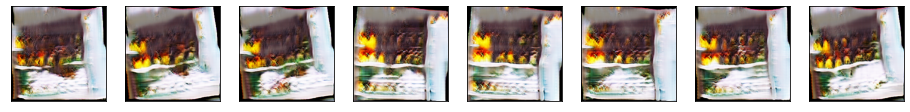

===> Epoch[24](1/54): Loss_D: 0.1808 Loss_G: 1.2274
===> Epoch[24](2/54): Loss_D: 0.1810 Loss_G: 1.2190
===> Epoch[24](3/54): Loss_D: 0.1580 Loss_G: 1.2702
===> Epoch[24](4/54): Loss_D: 0.1222 Loss_G: 1.4321
===> Epoch[24](5/54): Loss_D: 0.1564 Loss_G: 1.2696
===> Epoch[24](6/54): Loss_D: 0.2066 Loss_G: 1.2340
===> Epoch[24](7/54): Loss_D: 0.2078 Loss_G: 1.2908
===> Epoch[24](8/54): Loss_D: 0.1833 Loss_G: 1.2465
===> Epoch[24](9/54): Loss_D: 0.1380 Loss_G: 1.3931
===> Epoch[24](10/54): Loss_D: 0.2125 Loss_G: 1.5383
===> Epoch[24](11/54): Loss_D: 0.2926 Loss_G: 1.2652
===> Epoch[24](12/54): Loss_D: 0.3815 Loss_G: 1.8103
===> Epoch[24](13/54): Loss_D: 0.3187 Loss_G: 1.1399
===> Epoch[24](14/54): Loss_D: 0.1957 Loss_G: 1.0707
===> Epoch[24](15/54): Loss_D: 0.1972 Loss_G: 1.3610
===> Epoch[24](16/54): Loss_D: 0.1910 Loss_G: 1.2188
===> Epoch[24](17/54): Loss_D: 0.1439 Loss_G: 1.1082
===> Epoch[24](18/54): Loss_D: 0.2208 Loss_G: 0.9752
===> Epoch[24](19/54): Loss_D: 0.2114 Loss_G: 1.0868
==

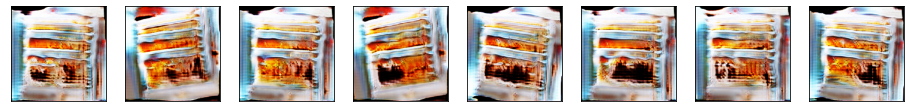

saving data .. 
===> Epoch[25](1/54): Loss_D: 0.2210 Loss_G: 1.1612
===> Epoch[25](2/54): Loss_D: 0.1510 Loss_G: 1.2792
===> Epoch[25](3/54): Loss_D: 0.1294 Loss_G: 1.4689
===> Epoch[25](4/54): Loss_D: 0.1278 Loss_G: 1.4271
===> Epoch[25](5/54): Loss_D: 0.1625 Loss_G: 1.3352
===> Epoch[25](6/54): Loss_D: 0.1682 Loss_G: 1.2288
===> Epoch[25](7/54): Loss_D: 0.2077 Loss_G: 1.5438
===> Epoch[25](8/54): Loss_D: 0.1658 Loss_G: 1.5867
===> Epoch[25](9/54): Loss_D: 0.2291 Loss_G: 1.0640
===> Epoch[25](10/54): Loss_D: 0.2153 Loss_G: 2.1004
===> Epoch[25](11/54): Loss_D: 0.1726 Loss_G: 1.2564
===> Epoch[25](12/54): Loss_D: 0.1729 Loss_G: 1.3139
===> Epoch[25](13/54): Loss_D: 0.1195 Loss_G: 1.5808
===> Epoch[25](14/54): Loss_D: 0.1517 Loss_G: 1.2473
===> Epoch[25](15/54): Loss_D: 0.1646 Loss_G: 1.3154
===> Epoch[25](16/54): Loss_D: 0.1677 Loss_G: 1.1667
===> Epoch[25](17/54): Loss_D: 0.1696 Loss_G: 1.4243
===> Epoch[25](18/54): Loss_D: 0.1334 Loss_G: 1.1592
===> Epoch[25](19/54): Loss_D: 0.1416 L

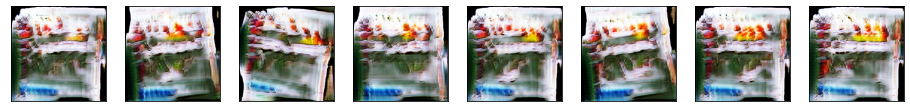

===> Epoch[26](1/54): Loss_D: 0.2167 Loss_G: 1.2490
===> Epoch[26](2/54): Loss_D: 0.1864 Loss_G: 1.2501
===> Epoch[26](3/54): Loss_D: 0.1944 Loss_G: 1.0256
===> Epoch[26](4/54): Loss_D: 0.1683 Loss_G: 1.1021
===> Epoch[26](5/54): Loss_D: 0.1842 Loss_G: 1.2697
===> Epoch[26](6/54): Loss_D: 0.2036 Loss_G: 1.0325
===> Epoch[26](7/54): Loss_D: 0.1745 Loss_G: 1.2134
===> Epoch[26](8/54): Loss_D: 0.1961 Loss_G: 1.1432
===> Epoch[26](9/54): Loss_D: 0.1833 Loss_G: 1.1340
===> Epoch[26](10/54): Loss_D: 0.1979 Loss_G: 1.1512
===> Epoch[26](11/54): Loss_D: 0.1450 Loss_G: 1.1328
===> Epoch[26](12/54): Loss_D: 0.1947 Loss_G: 1.3200
===> Epoch[26](13/54): Loss_D: 0.1470 Loss_G: 1.2034
===> Epoch[26](14/54): Loss_D: 0.1662 Loss_G: 1.0657
===> Epoch[26](15/54): Loss_D: 0.1904 Loss_G: 1.1296
===> Epoch[26](16/54): Loss_D: 0.1399 Loss_G: 1.2814
===> Epoch[26](17/54): Loss_D: 0.1576 Loss_G: 1.0967
===> Epoch[26](18/54): Loss_D: 0.1698 Loss_G: 0.9971
===> Epoch[26](19/54): Loss_D: 0.1615 Loss_G: 1.3545
==

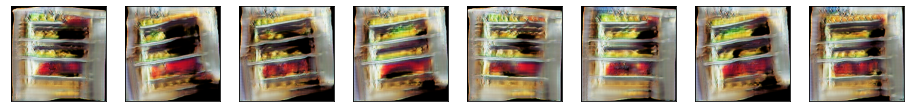

===> Epoch[27](1/54): Loss_D: 0.2165 Loss_G: 1.1837
===> Epoch[27](2/54): Loss_D: 0.2141 Loss_G: 1.0763
===> Epoch[27](3/54): Loss_D: 0.2074 Loss_G: 1.1129
===> Epoch[27](4/54): Loss_D: 0.1730 Loss_G: 1.2074
===> Epoch[27](5/54): Loss_D: 0.1811 Loss_G: 1.2218
===> Epoch[27](6/54): Loss_D: 0.2159 Loss_G: 1.0571
===> Epoch[27](7/54): Loss_D: 0.2124 Loss_G: 1.1163
===> Epoch[27](8/54): Loss_D: 0.2102 Loss_G: 1.1697
===> Epoch[27](9/54): Loss_D: 0.2093 Loss_G: 1.2181
===> Epoch[27](10/54): Loss_D: 0.2176 Loss_G: 1.1125
===> Epoch[27](11/54): Loss_D: 0.1977 Loss_G: 1.7825
===> Epoch[27](12/54): Loss_D: 0.3151 Loss_G: 1.1572
===> Epoch[27](13/54): Loss_D: 0.3438 Loss_G: 1.4007
===> Epoch[27](14/54): Loss_D: 0.2482 Loss_G: 1.2704
===> Epoch[27](15/54): Loss_D: 0.2140 Loss_G: 1.0600
===> Epoch[27](16/54): Loss_D: 0.1693 Loss_G: 1.1703
===> Epoch[27](17/54): Loss_D: 0.2166 Loss_G: 1.3608
===> Epoch[27](18/54): Loss_D: 0.2065 Loss_G: 1.0353
===> Epoch[27](19/54): Loss_D: 0.1520 Loss_G: 1.0773
==

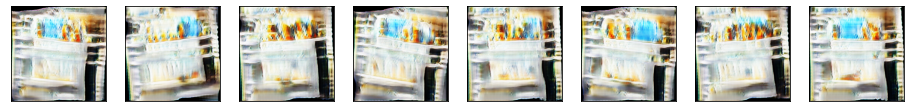

===> Epoch[28](1/54): Loss_D: 0.1677 Loss_G: 1.2016
===> Epoch[28](2/54): Loss_D: 0.2214 Loss_G: 1.2970
===> Epoch[28](3/54): Loss_D: 0.2071 Loss_G: 1.2516
===> Epoch[28](4/54): Loss_D: 0.1789 Loss_G: 1.1229
===> Epoch[28](5/54): Loss_D: 0.1725 Loss_G: 1.3627
===> Epoch[28](6/54): Loss_D: 0.1699 Loss_G: 1.1926
===> Epoch[28](7/54): Loss_D: 0.1648 Loss_G: 1.1938
===> Epoch[28](8/54): Loss_D: 0.1804 Loss_G: 1.3725
===> Epoch[28](9/54): Loss_D: 0.1681 Loss_G: 1.3432
===> Epoch[28](10/54): Loss_D: 0.1931 Loss_G: 1.0706
===> Epoch[28](11/54): Loss_D: 0.1567 Loss_G: 1.3768
===> Epoch[28](12/54): Loss_D: 0.1871 Loss_G: 1.0299
===> Epoch[28](13/54): Loss_D: 0.1664 Loss_G: 1.2871
===> Epoch[28](14/54): Loss_D: 0.1374 Loss_G: 1.3112
===> Epoch[28](15/54): Loss_D: 0.1578 Loss_G: 1.0612
===> Epoch[28](16/54): Loss_D: 0.2427 Loss_G: 1.0599
===> Epoch[28](17/54): Loss_D: 0.2243 Loss_G: 1.3147
===> Epoch[28](18/54): Loss_D: 0.1929 Loss_G: 1.2384
===> Epoch[28](19/54): Loss_D: 0.1857 Loss_G: 1.2540
==

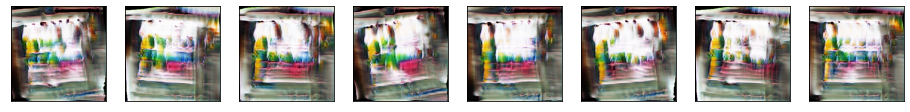

===> Epoch[29](1/54): Loss_D: 0.1730 Loss_G: 1.0965
===> Epoch[29](2/54): Loss_D: 0.2096 Loss_G: 1.0986
===> Epoch[29](3/54): Loss_D: 0.1352 Loss_G: 1.3587
===> Epoch[29](4/54): Loss_D: 0.1800 Loss_G: 1.1352
===> Epoch[29](5/54): Loss_D: 0.2123 Loss_G: 1.1332
===> Epoch[29](6/54): Loss_D: 0.2435 Loss_G: 1.0371
===> Epoch[29](7/54): Loss_D: 0.2014 Loss_G: 1.2995
===> Epoch[29](8/54): Loss_D: 0.1612 Loss_G: 1.1282
===> Epoch[29](9/54): Loss_D: 0.2130 Loss_G: 1.0702
===> Epoch[29](10/54): Loss_D: 0.1746 Loss_G: 1.1576
===> Epoch[29](11/54): Loss_D: 0.1885 Loss_G: 1.2836
===> Epoch[29](12/54): Loss_D: 0.2129 Loss_G: 1.0892
===> Epoch[29](13/54): Loss_D: 0.2297 Loss_G: 1.0414
===> Epoch[29](14/54): Loss_D: 0.2215 Loss_G: 1.1936
===> Epoch[29](15/54): Loss_D: 0.2027 Loss_G: 1.1675
===> Epoch[29](16/54): Loss_D: 0.1681 Loss_G: 1.1142
===> Epoch[29](17/54): Loss_D: 0.1689 Loss_G: 1.3285
===> Epoch[29](18/54): Loss_D: 0.2131 Loss_G: 1.2235
===> Epoch[29](19/54): Loss_D: 0.2198 Loss_G: 1.0941
==

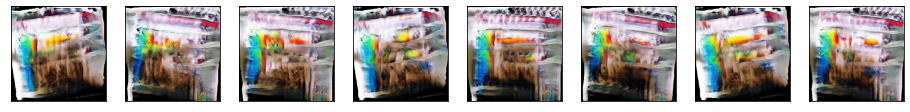

saving data .. 


In [23]:
trainingLoop(trainLoader, testLoader, n_epochs)

In [ ]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv)
  if batch_norm:
    batch_norm_layer = nn.BatchNorm2d(out_channels)
    layers.append(batch_norm_layer)

  return nn.Sequential(*layers)

In [ ]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv)
  if batch_norm:
    batchNorm = nn.BatchNorm2d(out_channels)
    layers.append(batchNorm)

  return nn.Sequential(*layers)

In [ ]:
def in_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  conv1 = conv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)
  conv2 = conv(out_channel, out_channel, kernel_size, stride, padding, batchNorm)

  layers = [conv1, conv2]

  return nn.Sequential(*layers)

In [ ]:
def down_samp_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  pool_layer = nn.MaxPool2d(2, 2)
  conv_layers = in_conv(in_channel, out_channel, batchNorm)

  layers = [pool_layer, conv_layers]
  return nn.Sequential(*layers)

In [ ]:
def up_samp_conv(in_channel, out_channel, batchNorm, kernel_size=4, stride=2, padding=1):
  deconv_layer = deconv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)

  return nn.Sequential(deconv_layer)

In [ ]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42
    ## input 3x256x256
    self.in_layer = in_conv(3, conv_dims, True) ## 32x128x128 32x256x256

    self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x64x64  64x128x128
    self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x32x32 128x64x64
    self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x16x16 256x32x32
    self.down_samp_conv4 = down_samp_conv(conv_dims*8, conv_dims*16, True) ## 512x16x16

    self.up_samp_conv0 = up_samp_conv(conv_dims*16, conv_dims*8, True) ## 256x32x32
    self.up_concat_conv0 = in_conv(conv_dims*16, conv_dims*8, True) 
    self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x64x64
    self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x128x128
    self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x256x256
    self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    self.out_layer = nn.Sequential(*[conv(conv_dims, 3, kernel_size=3, stride=1, batch_norm=True),  
                                     conv(3, 3, kernel_size=3, stride=1)])                   ## 3x256x256
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x256x256
    l1 = F.relu(self.in_layer(x)) ## 32x256x256
    d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x128x128
    d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x64x64
    d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x32x32
    d_l5 = F.relu(self.down_samp_conv4(d_l4)) ## 512x16x16

    up_l0 = F.relu(self.up_samp_conv0(d_l5)) ## 256x32x32
    up_l0_concat = torch.cat([up_l0, d_l4], dim=1) ## 512x32x32
    up_l0_concat = F.relu(self.up_concat_conv0(up_l0_concat)) ## 256x32x32

    up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x64x64
    up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x32x32
    up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x64x64

    up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x128x128
    up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x128x128
    up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x128x128

    up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x256x256
    up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x256x256
    up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x256x256

    out_layer = torch.tanh(self.out_layer(up_l3)) ## 3x256x236

    return out_layer


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Discriminator, self).__init__()
    
    self.conv1 = conv(3, conv_dims)   ## 32x128x128
    self.conv2 = conv(conv_dims, conv_dims*2, batch_norm=True)  ## 64x64x64
    self.conv3 = conv(conv_dims*2, conv_dims*4, batch_norm=True)  ## 128x32x32
    self.conv4 = conv(conv_dims*4, conv_dims*8, batch_norm=True)  ## 256x16x16

    self.fc = nn.Linear(256*16*16, 1)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = x.view(-1, 16*16*256)

    return self.fc(x)



In [ ]:
G, D = Generator(), Discriminator()
G = G.to(device)
D = D.to(device)
G.load_state_dict(torch.load(synthetic_imgs + 'checkpoint_G.pth'))
D.load_state_dict(torch.load(synthetic_imgs + 'checkpoint_D.pth'))

<All keys matched successfully>

In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

  ## https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/pix2pix_model.py

In [ ]:
lr = 0.001
beta1 = 0.5
beta2 = 0.99

g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

In [ ]:
import pickle as pkl 

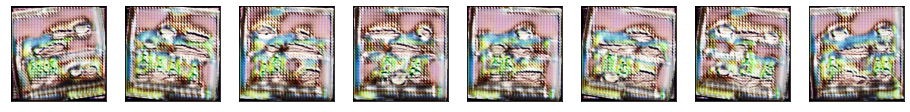

In [ ]:
iter_test_imgs = iter(testLoader)
indImg_test, synImg_test = next(iter_test_imgs)
indImg_test = scale(indImg_test)
synImg_test = scale(synImg_test)

if train_on_gpu:
  indImg_test = indImg_test.cuda()
  synImg_test = synImg_test.cuda()

fakeImg = G(synImg_test)
samples.append(fakeImg)
_ = view_samples(-1, samples)

In [ ]:
def EXtrainingLoop(trainLoader, valLoader, n_epochs):
  min_loss = 10000.0

  iter_train_imgs = iter(trainLoader)
  iter_test_imgs = iter(testLoader)

  train_loss_deque = deque(maxlen=10)
  batch_per_epochs_train = len(trainLoader)
  batch_per_epoch_test = len(testLoader)

  for epoch in range(n_epochs):
    if epoch % batch_per_epochs_train == 0:
      iter_train_imgs = iter(trainLoader)

    indImg, synImg = next(iter_train_imgs)
    indImg = scale(indImg)
    synImg = scale(synImg)

    ## Discriminator Loss 
    d_optimizer.zero_grad()
    # if train_on_gpu:
    #   indImg = indImg.cuda()
    #   synImg = synImg.cuda()

    real_pred = D(indImg)
    r_loss = real_loss(real_pred, smooth=True)

    fake_img = G(synImg)
    print(fake_img.shape)
    fake_pred = D(fake_img)
    f_loss = fake_loss(fake_pred)

    d_loss = f_loss + r_loss 
    d_loss.backward()
    d_optimizer.step()

    ## Generator Loss 
    g_optimizer.zero_grad()

    fake_img = G(synImg)
    fake_pred = D(fake_img)
    g_loss = real_loss(fake_pred)

    g_loss.backward()
    g_optimizer.step()

  # if batch_index % print_every == 0:
    losses.append((d_loss.item(), g_loss.item()))
    print(' Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  epoch + 1, n_epochs, d_loss.item(), g_loss.item()))
    
    G.eval()
    with torch.no_grad():
      if epoch % batch_per_epoch_test == 0:
        iter_test_imgs = iter(testLoader)
      indImg_test, synImg_test = next(iter_test_imgs)
      indImg_test = scale(indImg_test)
      synImg_test = scale(synImg_test)

      # if train_on_gpu:
      #   indImg_test = indImg_test.cuda()
      #   synImg_test = synImg_test.cuda()

      fakeImg = G(synImg_test)
      samples.append(fakeImg)
      _ = view_samples(-1, samples)

    G.train()

    if (epoch+1) % 10 == 0:
      print('saving data .. ')
      torch.save(G.state_dict(), synthetic_imgs + 'checkpoint_G.pth')
      torch.save(D.state_dict(),  synthetic_imgs + 'checkpoint_D.pth')

      # pkl_file = open(synthetic_imgs +  'Fride_train_samples_2.pkl', 'wb')
      # pkl.dump(samples, pkl_file)
      # pkl_file.close()





In [ ]:
trainingLoop(trainLoader, testLoader, n_epochs)